In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pandas as pd

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

from matplotlib.colorbar import ColorbarBase

In [3]:
import cmocean

In [4]:
import graphufs
from graphufs.spatialmap import SpatialMap
plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [6]:
ds = xr.open_zarr("/p2-lustre/p2/long-forecasts/graphufs.2019-01-01T03.2019-12-31T18.zarr/")
#sds = xr.open_zarr("/p1-evaluation/v1/long-forecasts/graphufs.2019-01-01T00.8754h.spectra.zarr/")
#sds = sds.sortby("latitude")
#eds = xr.open_dataset("/p1-evaluation/v1/long-forecasts/graphufs_vs_era5_8754h_deterministic_temporal.nc")

In [12]:
ds.isel(time=slice(2)).compute()

<xarray.Dataset> Size: 51MB
Dimensions:         (time: 2, t0: 1, level: 16, lat: 192, lon: 384)
Coordinates:
  * lat             (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
    lead_time       (time) timedelta64[ns] 16B 03:00:00 06:00:00
  * level           (level) float64 128B 226.1 277.8 327.7 ... 874.7 922.6 974.3
  * lon             (lon) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * t0              (t0) datetime64[ns] 8B 2019-01-01T03:00:00
  * time            (time) datetime64[ns] 16B 2019-01-01T06:00:00 2019-01-01T...
Data variables:
    dzdt            (time, t0, level, lat, lon) float32 9MB nan nan ... nan nan
    pressfc         (time, t0, lat, lon) float32 590kB nan nan nan ... nan nan
    spfh            (time, t0, level, lat, lon) float32 9MB nan nan ... nan nan
    spfh2m          (time, t0, lat, lon) float32 590kB nan nan nan ... nan nan
    tmp             (time, t0, level, lat, lon) float32 9MB nan nan ... nan nan
    tmp2m           (time, t0, lat, lon) float32 590kB nan nan nan ... nan nan
    ugrd            (time, t0, level, lat, lon) float32 9MB nan nan ... nan nan
    ugrd10m         (time, t0, lat, lon) float32 590kB nan nan nan ... nan nan
    vgrd            (time, t0, level, lat, lon) float32 9MB nan nan ... nan nan
    vgrd10m         (time, t0, lat, lon) float32 590kB nan nan nan ... nan nan
    10m_wind_speed  (time, t0, lat, lon) float32 590kB nan nan nan ... nan nan

In [7]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        ds.time.isel(time=0).values,
        ds.time.isel(time=-1).values
    ),
    level=[250,500,850],
)

In [7]:
sds.load();

In [8]:
sds.time

<xarray.DataArray 'time' (time: 2917)> Size: 23kB
array(['2019-01-01T06:00:00.000000000', '2019-01-01T09:00:00.000000000',
       '2019-01-01T12:00:00.000000000', ..., '2019-12-31T12:00:00.000000000',
       '2019-12-31T15:00:00.000000000', '2019-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 23kB 2019-01-01T06:00:00 ... 2019-12-31T18...

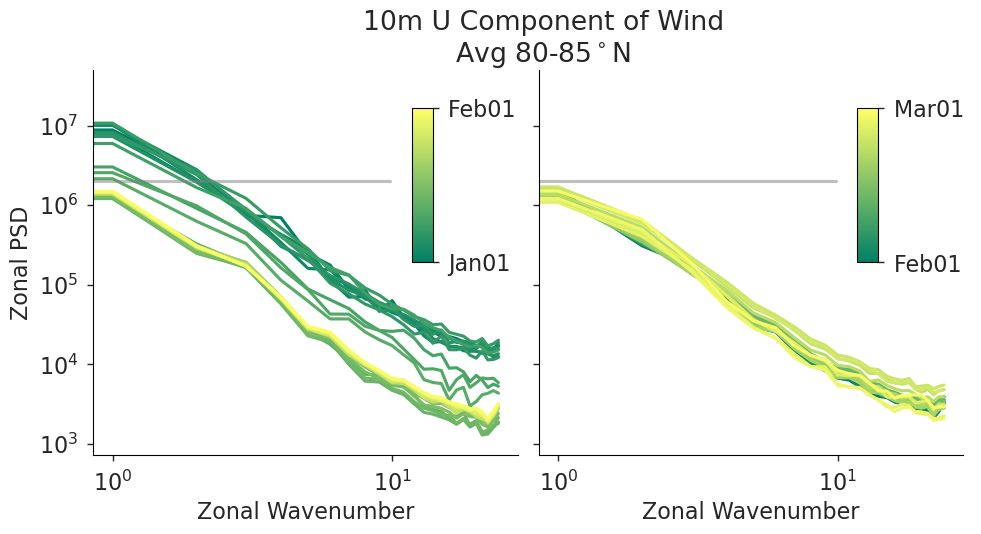

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True, sharex=True)

cmap = "summer"
xda = sds["10m_u_component_of_wind"].sel(latitude=slice(80,85))

for timesel, ax in zip(
    [pd.date_range("2019-01-01T06", "2019-02-01T06", freq="24h"),
     pd.date_range("2019-02-01T06", "2019-03-01T06", freq="24h")],
    axs,
):
    n_time = len(timesel)
    for i, time in enumerate(timesel):
        plotme = xda.sel(time=time)
        plotme = plotme.mean("latitude")
        plotme.plot(
            ax=ax,
            yscale="log",
            xscale="log",
            color=plt.get_cmap(cmap)(int(i/n_time * 256)),
        )
    fig.subplots_adjust(right=.85)
    cax = ax.inset_axes([.75, .5, .05, .4])
    cbar = ColorbarBase(cax, cmap=plt.get_cmap(cmap), orientation="vertical", ticks=[0, 1])
    cbar.ax.set_yticklabels([str(t)[5:11].replace("01-", "Jan").replace("02-","Feb").replace("03-","Mar") for t in [timesel[0], timesel[-1]]])
    
    ax.set(
        ylabel="Zonal PSD" if ax.get_subplotspec().is_first_col() else "",
        xlabel="Zonal Wavenumber",
        title="",
        ylim=(None, 5e7),
    )
    ax.axhline(2e6, xmax=.7, color="gray", alpha=.5)
fig.subplots_adjust(wspace=.05)
fig.suptitle("10m U Component of Wind\nAvg 80-85$^\circ$N", y=1.)
fig.savefig("figures/long_forecast_spectrum_2019_ugrd10m.jpeg", bbox_inches="tight", dpi=300)

In [8]:
mapper = SpatialMap()

In [9]:
ds["10m_wind_speed"] = np.sqrt(ds["ugrd10m"]**2 + ds["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


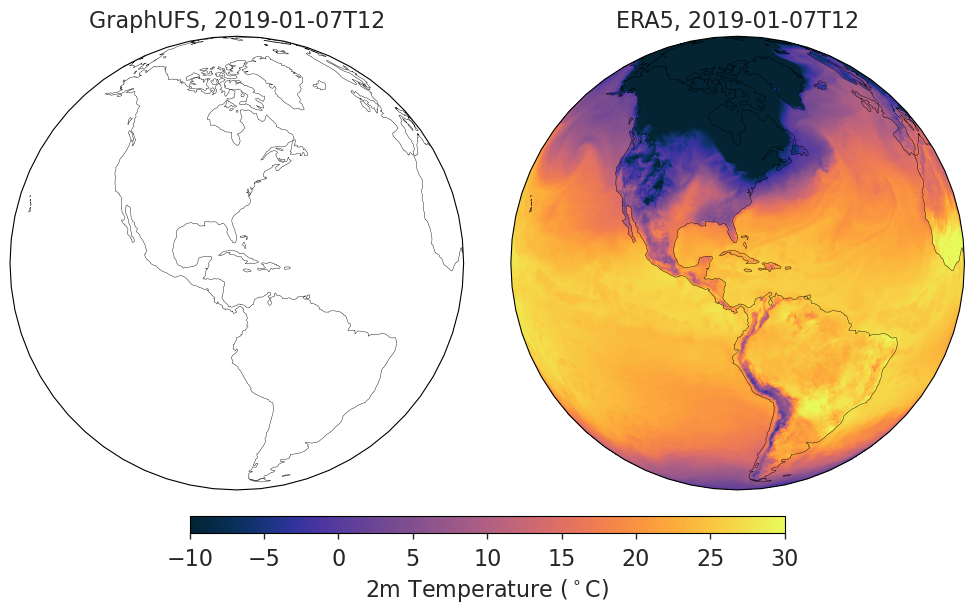

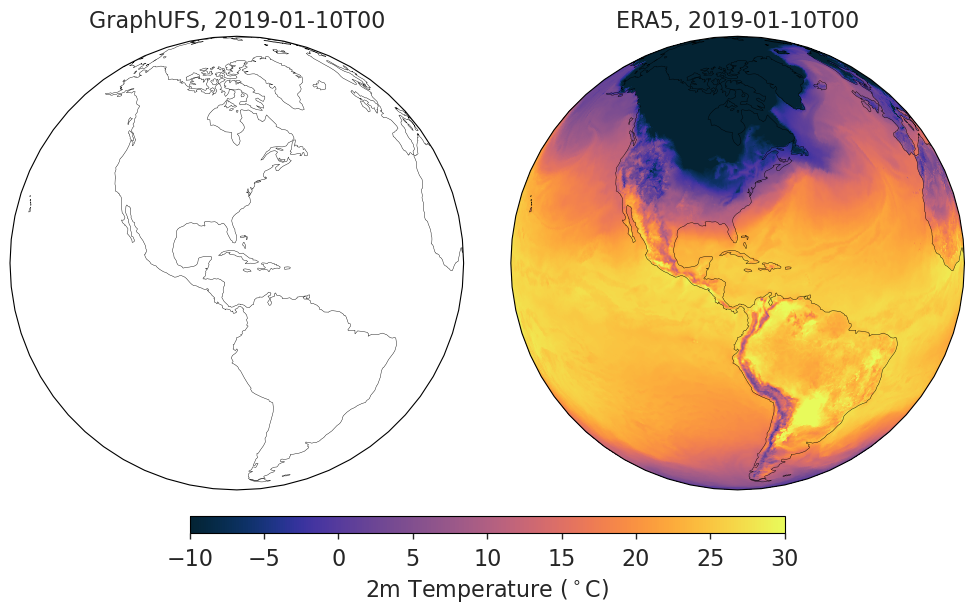

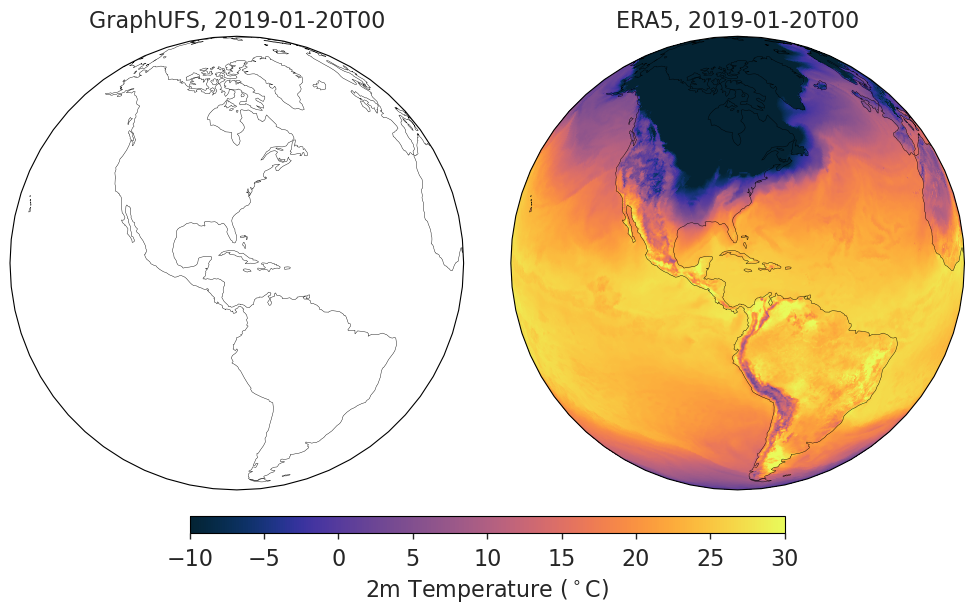

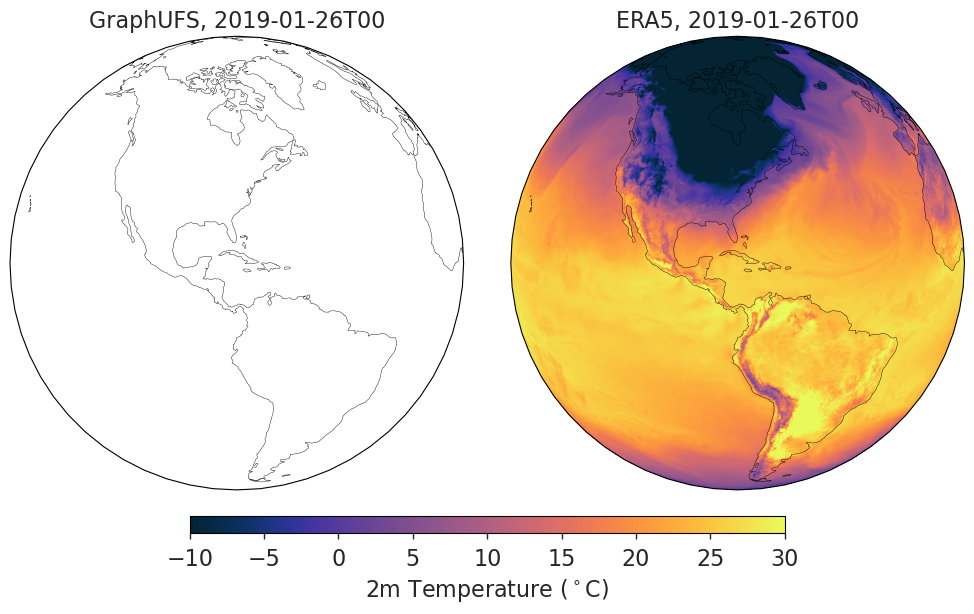

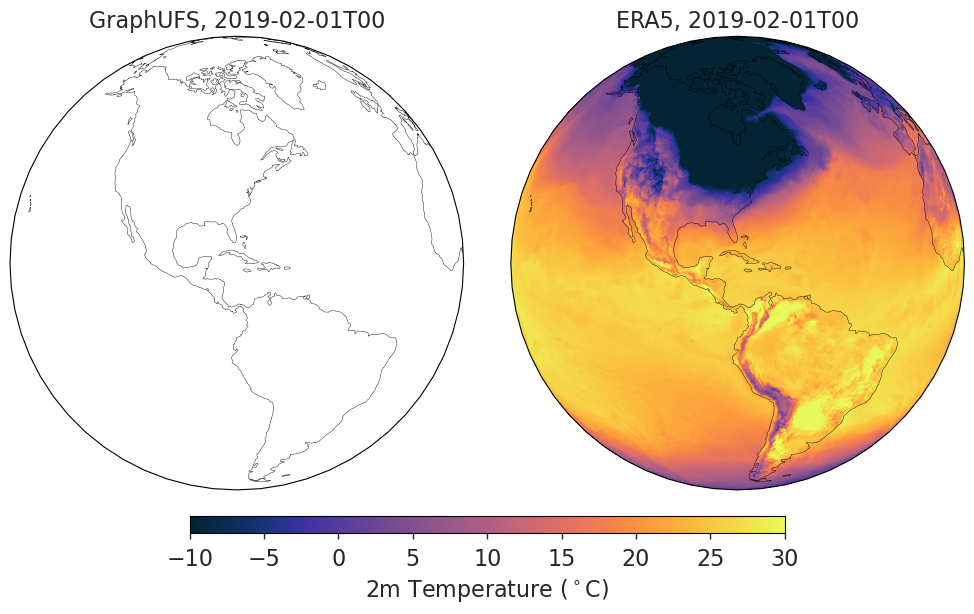

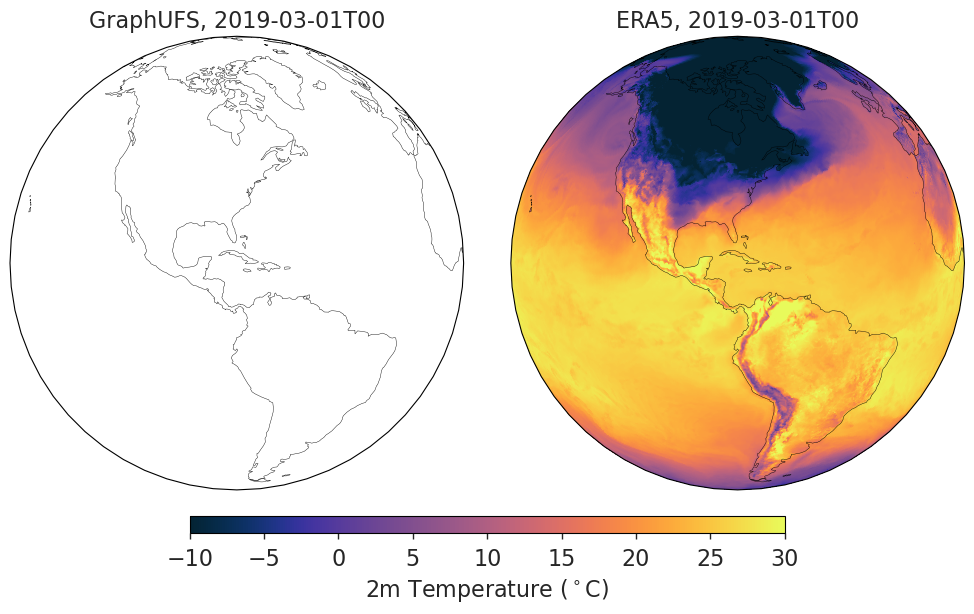

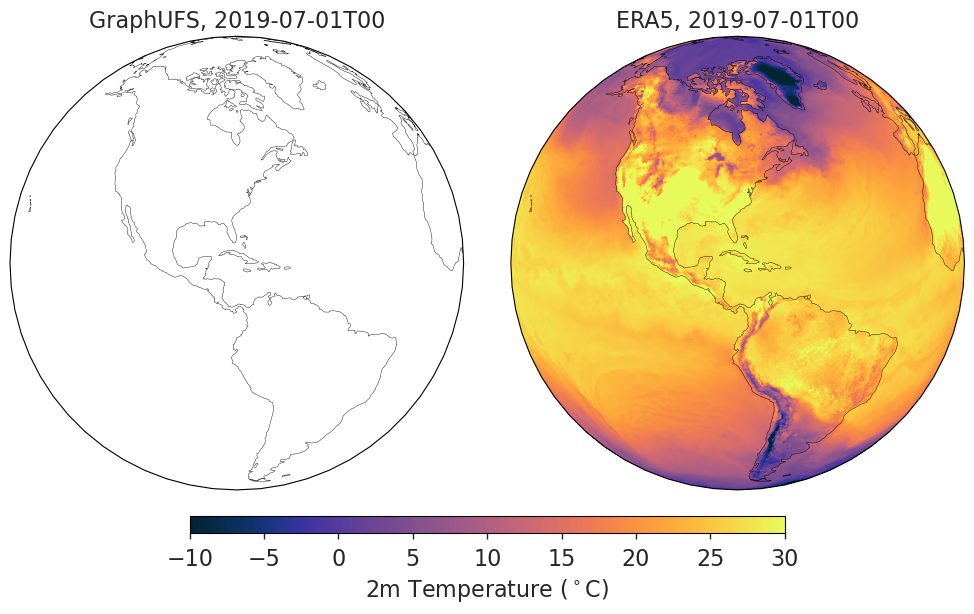

In [10]:
dates = [
    "2019-01-07T12",
    "2019-01-10T00",
    "2019-01-20T00",
    "2019-01-26T00",
    "2019-02-01T00",
    "2019-03-01T00",
    "2019-07-01T00",
]

#dates = ["2019-01-08T00"]

for date in dates:
    fig, axs = mapper.plot(
        ds["tmp2m"].sel(time=date),
        era["2m_temperature"].sel(time=[date]),
    );
    fig.savefig(f"figures/long_forecast_tmp2m_{date}.jpeg", bbox_inches="tight", dpi=300)

In [179]:
import xmovie

In [195]:
def custom_func(xds, fig, idate, *args, **kwargs):

    gda = xds["tmp2m"].isel(time=idate)
    erada = xds["2m_temperature"].sel(time=[gda.time.values])

    gda = gda-273.15
    erada = erada-273.15

    axs = [fig.add_subplot(1, 2, i) for i in [1, 2]]
    gda.plot(ax=axs[0], **kwargs)
    erada.plot(ax=axs[1], **kwargs)
    for ax in axs:
        ax.set(
            ylabel="",
            xlabel="",
        )
    axs[0].set(title=f"GraphUFS, fhr = {(idate+1)*6}h")
    axs[1].set(title=f"ERA5, {str(erada.time.values[0])[:13]}")
    
    return None, None

In [200]:
gda = ds["tmp2m"].isel(time=slice(100)).load()
eda = era["2m_temperature"].sel(time=gda.time.values).load();

In [201]:
mymovie = xmovie.Movie(
    xr.Dataset({
        "tmp2m": gda,
        "2m_temperature": eda,
    }),
    custom_func,
    input_check=False,
    cmap="cmo.thermal",
    vmin=-10,
    vmax=30,
)

In [202]:
mymovie.save("figures/long_forecast_tmp2m.mp4", progress=True, overwrite_existing=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Movie created at long_forecast_tmp2m.mp4


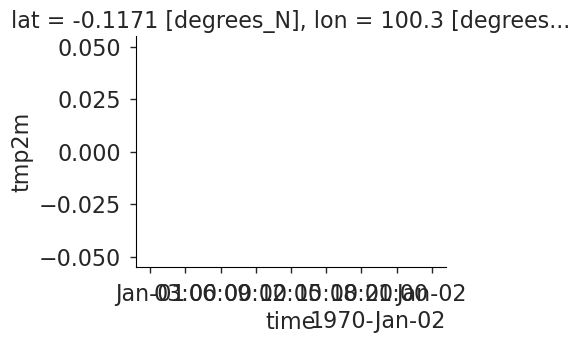

In [12]:
ds.tmp2m.squeeze().sel(lat=0, lon=100, method="nearest").plot()

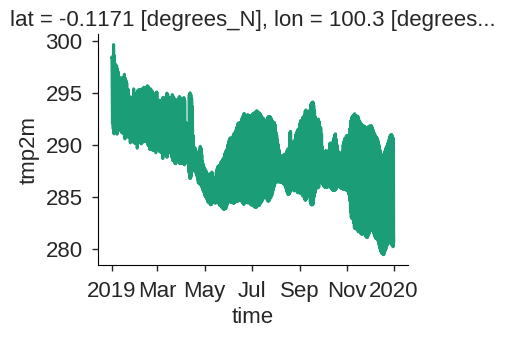

In [13]:
ds.tmp2m.squeeze().sel(lat=0, lon=100, method="nearest").plot()

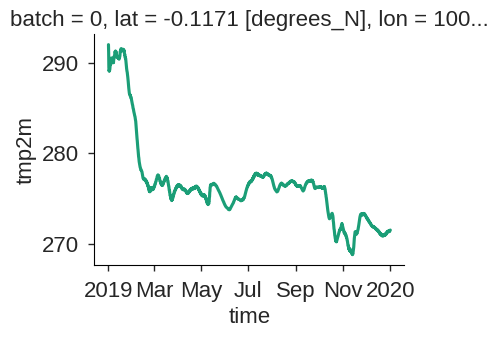

In [18]:
ds.tmp2m.squeeze().sel(lat=0, lon=100, method="nearest").plot()

In [ ]:
ds.tmp2m